In [1]:
%matplotlib inline

In [2]:
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

In [3]:
DEVICE_ID = 1
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

In [4]:
### Для запуска без GPU раскомментировать и закоментировать код выше
# DEVICE = torch.device('cpu')

In [5]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [7]:
DATA_PATH  = '/home/azamat.sultanov/hw4/'
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'

In [8]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [9]:
np_mean.shape

(3,)

In [10]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [11]:
dataset_train_norm = CifarDataset(DATA_PATH + train_path, transform=cifar_transform_norm)
dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        shuffle=True, num_workers=4)

dataset_test_norm = CifarDataset(DATA_PATH + test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=80,
                  a_batch_size=128,
                  a_lr=0.1):
    
    train_acc = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)

    
    for epoch in tqdm_notebook(range(a_epochs)):  # loop over the dataset multiple times
        if epoch == 42:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 65:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.0001, momentum=0.9) 
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_accuracy += accuracy_score(labels, prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        
        print("Epoch ", epoch, round(train_acc[-1], 4))

    print('Finished Training')
    
    plt.plot(train_acc, label='Train')
    plt.legend()
    plt.grid()

In [12]:
class StupidDenseNet(nn.Module):
    
    def __init__(self):
        super(StupidDenseNet, self).__init__()
        
        self.classifier = nn.Sequential()
        self.classifier.add_module('lin1', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig1', torch.nn.Sigmoid())
        self.classifier.add_module('lin2', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig2', torch.nn.Sigmoid())
        self.classifier.add_module('lin3', nn.Linear(3*32*32, 500))
        self.classifier.add_module('sig3', torch.nn.Sigmoid())
        
    def forward(self, x):
        x = self.classifier(x)
        return x

In [13]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #Увеличиваем кол-во выходных слоев с 84 - до 84*2 - потому что классов 100
        self.fc2 = nn.Linear(120, 84*2)
        self.fc3 = nn.Linear(84*2, 100)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [14]:
    def conv3x3(a_in_planes, a_out_planes, a_stride=1):
        return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                         kernel_size=3, padding=1, bias=False)

    def x_downsample(a_in_channels, coef):
         return nn.Conv2d(a_in_channels, 
                   a_in_channels*coef,
                   kernel_size=1,
                   stride=coef,
                   bias=False)

    def bn(a_out_channels):
        return nn.BatchNorm2d(a_out_channels)

In [15]:
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True, DOWNSAMPLE_COEF = 2):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        self.make_downsample = make_downsample
        
        if make_downsample: coef = DOWNSAMPLE_COEF
        else: coef = 1  
            
        # сохранение исходных данных
        self.coef = coef
        self.a_in_channels = a_in_channels
        self.a_out_channels = a_in_channels * self.coef
        
        # создание слоя для сэмплинга
        if self.make_downsample:
            self.downsample = x_downsample(self.a_in_channels, self.coef)
            
        # создание конволюционных и батчнорм слоев
        self.conv1 = conv3x3(self.a_in_channels, self.a_out_channels, a_stride = self.coef)
        self.bn1 = bn(self.a_out_channels)
        
        self.conv2 = conv3x3(self.a_out_channels, self.a_out_channels)
        self.bn2 = bn(self.a_out_channels)
            
    def forward(self, x):
        residual_x = x
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        
        if self.use_skip_connection:
            if self.make_downsample:
                residual_x = self.downsample(residual_x)
            x += residual_x
            
        x = F.relu(x)
        
        return x

In [16]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()
                
        self.features = nn.Sequential()
        
        self.global_conv3x3 =  conv3x3(3,32)
        
        self.features.add_module('res_block1', CifarResidualBlock(32))
        self.features.add_module('res_block2', CifarResidualBlock(32))
        self.features.add_module('res_block3', CifarResidualBlock(32, make_downsample = True))
        
        self.features.add_module('res_block4', CifarResidualBlock(64))
        self.features.add_module('res_block5', CifarResidualBlock(64))
        self.features.add_module('res_block6', CifarResidualBlock(64))
        self.features.add_module('res_block7', CifarResidualBlock(64, make_downsample = True))
        
        self.features.add_module('res_block8', CifarResidualBlock(128))
        self.features.add_module('res_block9', CifarResidualBlock(128))
        self.features.add_module('res_block10', CifarResidualBlock(128))
        self.features.add_module('res_block11', CifarResidualBlock(128, make_downsample = True))
        
        self.features.add_module('res_block12', CifarResidualBlock(256))
        self.features.add_module('res_block13', CifarResidualBlock(256))
        self.features.add_module('res_block14', CifarResidualBlock(256))
        self.features.add_module('res_block15', CifarResidualBlock(256, make_downsample = True))
        
        
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=2)
        self.fc_classifier = nn.Linear(512, 100)
        
    def forward(self, x):
        x = self.global_conv3x3(x)
        x = self.features(x)
        x = self.global_avg_pooling(x) 
        x = x.view((x.size()[0], -1))        
        x = self.fc_classifier(x)        
        return x

In [17]:
# dense_net = StupidDenseNet()
# %time train_network(dense_net, torch.device(DEVICE))

In [18]:
# lenet = LeNet()
# %time train_network(lenet, torch.device('cpu'), a_epochs=10)

In [19]:
# lenet = LeNet()
# %time train_network(lenet, torch.device(DEVICE), a_epochs=10)

In [20]:
# lenet = LeNet()
# %time train_network(lenet, torch.device(DEVICE))

Epoch  0 0.0813
Epoch  1 0.1692
Epoch  2 0.2338
Epoch  3 0.2906
Epoch  4 0.3409
Epoch  5 0.3879
Epoch  6 0.4254
Epoch  7 0.4629
Epoch  8 0.4929
Epoch  9 0.5197
Epoch  10 0.5415
Epoch  11 0.5635
Epoch  12 0.5797
Epoch  13 0.5977
Epoch  14 0.6131
Epoch  15 0.6285
Epoch  16 0.6453
Epoch  17 0.6541
Epoch  18 0.6632
Epoch  19 0.6806
Epoch  20 0.687
Epoch  21 0.6976
Epoch  22 0.7042
Epoch  23 0.7185
Epoch  24 0.7265
Epoch  25 0.732
Epoch  26 0.7402
Epoch  27 0.7495
Epoch  28 0.7562
Epoch  29 0.7614
Epoch  30 0.7719
Epoch  31 0.7732
Epoch  32 0.7807
Epoch  33 0.7836
Epoch  34 0.7953
Epoch  35 0.8044
Epoch  36 0.804
Epoch  37 0.8073
Epoch  38 0.8161
Epoch  39 0.8193
Epoch  40 0.8204
Epoch  41 0.8236
Epoch  42 0.9172
Epoch  43 0.9478
Epoch  44 0.9572
Epoch  45 0.9627
Epoch  46 0.9685
Epoch  47 0.9719
Epoch  48 0.975
Epoch  49 0.9772
Epoch  50 0.9785
Epoch  51 0.9809
Epoch  52 0.9822
Epoch  53 0.9848
Epoch  54 0.9863
Epoch  55 0.9862
Epoch  56 0.9866
Epoch  57 0.9889
Epoch  58 0.9887
Epoch  59 0

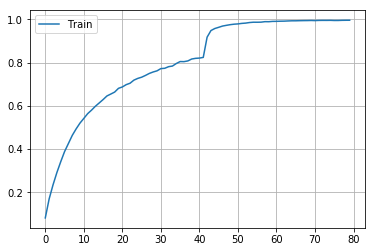

In [21]:
resnet = CifarResNet()
%time train_network(resnet, torch.device(DEVICE))

In [22]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [23]:
my_solution = make_solution(resnet, DEVICE)

In [24]:
with open('my_solution.csv', 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)